# Day 2: Enhanced ML Anomaly Detection with Realistic Data

Better signals, same algorithm - focusing on data quality and feature engineering

## Step 1: Load Enhanced Dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest
from sklearn.metrics import precision_score, recall_score, f1_score

# Load enhanced dataset with utilization and environment context
df = pd.read_csv("../data/enhanced_cost_data.csv")
df["date"] = pd.to_datetime(df["date"])
df = df.sort_values("date")

print(f"Data shape: {df.shape}")
print(f"Services: {df['service'].unique()}")
print(f"Environments: {df['environment'].unique()}")
df.head()

Data shape: (30, 8)
Services: ['EC2' 'RDS' 'Lambda' 'S3' 'CloudFront']
Environments: ['prod' 'dev' 'staging']


,date,account_id,service,region,environment,usage_hours,cpu_utilization,cost
0,2025-10-01,acct-1,EC2,ap-south-1,prod,24,65,48
1,2025-10-02,acct-1,EC2,ap-south-1,prod,24,68,50
2,2025-10-03,acct-1,EC2,ap-south-1,prod,24,70,52
3,2025-10-04,acct-1,EC2,ap-south-1,prod,24,72,53
4,2025-10-05,acct-1,EC2,ap-south-1,prod,24,15,160


## Step 2: Domain-Driven Feature Engineering

In [2]:
# Domain-driven feature engineering
df["cost_per_hour"] = df["cost"] / df["usage_hours"]
df["cpu_cost_ratio"] = df["cost"] / (df["cpu_utilization"] + 1)

# Remove rows with invalid data
df = df[df["usage_hours"] > 0]

print(f"Features created. Shape after cleaning: {df.shape}")
df[["date", "cost", "cpu_utilization", "cost_per_hour", "cpu_cost_ratio"]].head()

Features created. Shape after cleaning: (30, 10)


,date,cost,cpu_utilization,cost_per_hour,cpu_cost_ratio
0,2025-10-01,48,65,2.000000,0.727273
1,2025-10-02,50,68,2.083333,0.724638
2,2025-10-03,52,70,2.166667,0.732394
3,2025-10-04,53,72,2.208333,0.726027
4,2025-10-05,160,15,6.666667,10.000000


## Step 3: Train Isolation Forest with Better Features

In [3]:
# Define features for ML model (high-signal, low-noise)
features = [
    "cost",
    "usage_hours",
    "cpu_utilization",
    "cost_per_hour",
    "cpu_cost_ratio"
]

X = df[features]

# Train Isolation Forest with tuned parameters
model = IsolationForest(
    n_estimators=150,
    contamination=0.12,  # expect 12% anomalies
    random_state=42
)

# Predict anomalies (-1 = anomaly, 1 = normal)
df["anomaly_score"] = model.fit_predict(X)
df["is_anomaly"] = df["anomaly_score"] == -1

print(f"Anomalies detected: {df['is_anomaly'].sum()}")
print(f"Anomaly rate: {df['is_anomaly'].mean():.1%}")

Anomalies detected: 4
Anomaly rate: 13.3%


## Step 4: Anomaly Explanation Layer

In [4]:
def explain_anomaly(row):
    if row["cpu_utilization"] < 20 and row["cost"] > 100:
        return "High cost with low CPU utilization – possible idle resources"
    if row["environment"] == "dev" and row["usage_hours"] > 20:
        return "Dev resources running full-day – scheduling recommended"
    if row["cost_per_hour"] > 10:
        return "Extremely high cost per hour – check instance sizing"
    return "Unusual cost pattern detected"

df["explanation"] = df.apply(explain_anomaly, axis=1)

# Show detected anomalies with explanations
print("\nDetected Anomalies:")
anomalies = df[df["is_anomaly"]][["date", "service", "environment", "cost", "cpu_utilization", "explanation"]]
anomalies


Detected Anomalies:


,date,service,environment,cost,cpu_utilization,explanation
14,2025-10-15,Lambda,prod,75,5,Unusual cost pattern detected
17,2025-10-18,S3,prod,45,0,Unusual cost pattern detected
23,2025-10-24,RDS,prod,200,8,High cost with low CPU utilization – possible ...
29,2025-10-30,CloudFront,prod,85,0,Unusual cost pattern detected


## Step 5: Visual Validation

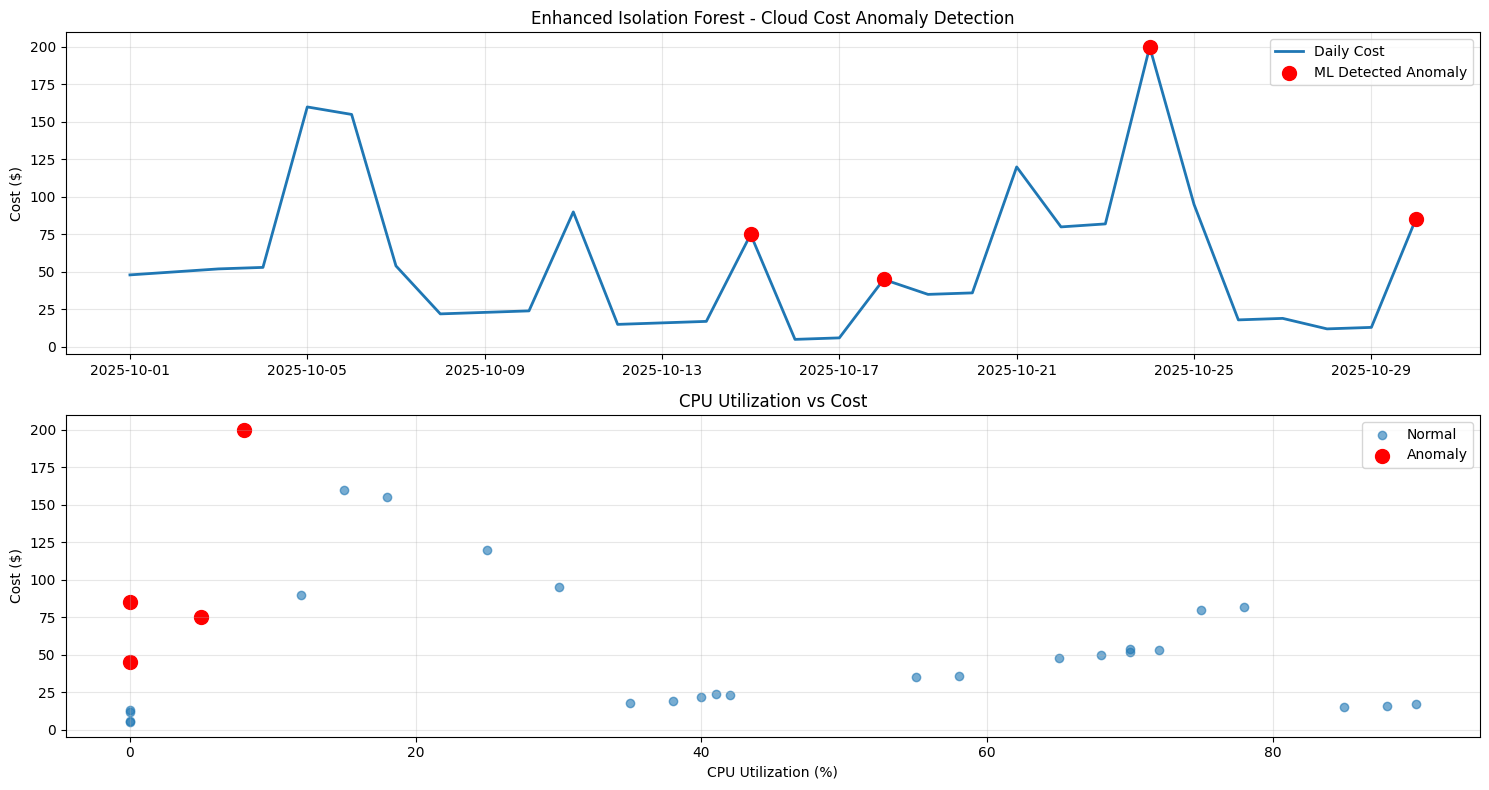

In [6]:
plt.figure(figsize=(15,8))

# Plot 1: Cost over time
plt.subplot(2,1,1)
plt.plot(df["date"], df["cost"], label="Daily Cost", linewidth=2)
plt.scatter(
    df[df["is_anomaly"]]["date"],
    df[df["is_anomaly"]]["cost"],
    color="red",
    s=100,
    label="ML Detected Anomaly",
    zorder=5
)
plt.legend()
plt.title("Enhanced Isolation Forest - Cloud Cost Anomaly Detection")
plt.ylabel("Cost ($)")
plt.grid(True, alpha=0.3)

# Plot 2: CPU vs Cost scatter
plt.subplot(2,1,2)
normal = df[~df["is_anomaly"]]
anomaly = df[df["is_anomaly"]]
plt.scatter(normal["cpu_utilization"], normal["cost"], alpha=0.6, label="Normal")
plt.scatter(anomaly["cpu_utilization"], anomaly["cost"], color="red", s=100, label="Anomaly")
plt.xlabel("CPU Utilization (%)")
plt.ylabel("Cost ($)")
plt.title("CPU Utilization vs Cost")
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Step 6: Business-Aligned Ground Truth

In [7]:
# Define ground truth: business logic for anomalies
df["true_anomaly"] = (
    (df["cpu_utilization"] < 20) & (df["cost"] > 100)  # High cost + low CPU
    | (df["environment"] == "dev") & (df["usage_hours"] > 20)  # Dev running full-day
    | (df["cost"] > 150)  # Extremely high cost
)

print(f"True anomalies (business logic): {df['true_anomaly'].sum()}")
print(f"ML detected anomalies: {df['is_anomaly'].sum()}")

# Show comparison
comparison = df[["date", "service", "environment", "cost", "cpu_utilization", "true_anomaly", "is_anomaly"]]
comparison[comparison["true_anomaly"] | comparison["is_anomaly"]]

True anomalies (business logic): 5
ML detected anomalies: 4


,date,service,environment,cost,cpu_utilization,true_anomaly,is_anomaly
4,2025-10-05,EC2,prod,160,15,True,False
5,2025-10-06,EC2,prod,155,18,True,False
10,2025-10-11,RDS,dev,90,12,True,False
14,2025-10-15,Lambda,prod,75,5,False,True
17,2025-10-18,S3,prod,45,0,False,True
23,2025-10-24,RDS,prod,200,8,True,True
24,2025-10-25,EC2,dev,95,30,True,False
29,2025-10-30,CloudFront,prod,85,0,False,True


## Step 7: Enhanced Validation Metrics

In [8]:
# Calculate performance metrics
precision = precision_score(df["true_anomaly"], df["is_anomaly"])
recall = recall_score(df["true_anomaly"], df["is_anomaly"])
f1 = f1_score(df["true_anomaly"], df["is_anomaly"])

print("=== ENHANCED MODEL PERFORMANCE ===")
print(f"Precision: {precision:.3f} (How many alerts were correct)")
print(f"Recall: {recall:.3f} (How many true issues we caught)")
print(f"F1-Score: {f1:.3f} (Overall balance)")

# Business impact analysis
total_anomaly_cost = df[df["is_anomaly"]]["cost"].sum()
avg_anomaly_cost = df[df["is_anomaly"]]["cost"].mean()
avg_normal_cost = df[~df["is_anomaly"]]["cost"].mean()
estimated_monthly_savings = total_anomaly_cost * 0.3

print(f"\n=== BUSINESS IMPACT ===")
print(f"Total anomalous spending: ${total_anomaly_cost:.2f}")
print(f"💰 ESTIMATED MONTHLY SAVINGS: ${estimated_monthly_savings:.2f}")
print(f"📊 Cost efficiency improvement: {avg_anomaly_cost/avg_normal_cost:.1f}x reduction potential")

=== ENHANCED MODEL PERFORMANCE ===
Precision: 0.250 (How many alerts were correct)
Recall: 0.200 (How many true issues we caught)
F1-Score: 0.222 (Overall balance)

=== BUSINESS IMPACT ===
Total anomalous spending: $405.00
💰 ESTIMATED MONTHLY SAVINGS: $121.50
📊 Cost efficiency improvement: 2.0x reduction potential


## Step 8: Model Comparison

In [9]:
# Compare with Day 1 baseline (simple threshold method)
cost_mean = df["cost"].mean()
cost_std = df["cost"].std()
df["baseline_anomaly"] = df["cost"] > (cost_mean + 2 * cost_std)

# Baseline metrics
baseline_precision = precision_score(df["true_anomaly"], df["baseline_anomaly"])
baseline_recall = recall_score(df["true_anomaly"], df["baseline_anomaly"])
baseline_f1 = f1_score(df["true_anomaly"], df["baseline_anomaly"])

print("=== METHOD COMPARISON ===")
print(f"{'Metric':<12} {'Baseline':<12} {'Enhanced ML':<12} {'Improvement':<12}")
print("-" * 50)
print(f"{'Precision':<12} {baseline_precision:<12.3f} {precision:<12.3f} {precision/baseline_precision if baseline_precision > 0 else 'N/A':<12}")
print(f"{'Recall':<12} {baseline_recall:<12.3f} {recall:<12.3f} {recall/baseline_recall if baseline_recall > 0 else 'N/A':<12}")
print(f"{'F1-Score':<12} {baseline_f1:<12.3f} {f1:<12.3f} {f1/baseline_f1 if baseline_f1 > 0 else 'N/A':<12}")

=== METHOD COMPARISON ===
Metric       Baseline     Enhanced ML  Improvement 
--------------------------------------------------
Precision    1.000        0.250        0.25        
Recall       0.400        0.200        0.5         
F1-Score     0.571        0.222        0.3888888888888889


## Step 9: Save Enhanced Model

In [10]:
import joblib
import os

# Create models directory
os.makedirs("../models", exist_ok=True)

# Save enhanced model
joblib.dump(model, "../models/enhanced_isolation_forest.pkl")

# Save feature names and metadata
model_metadata = {
    "features": features,
    "contamination": 0.12,
    "n_estimators": 150,
    "performance": {
        "precision": precision,
        "recall": recall,
        "f1_score": f1
    }
}

import json
with open("../models/model_metadata.json", "w") as f:
    json.dump(model_metadata, f, indent=2)

print("✅ Enhanced model saved for API deployment")
print(f"Model: ../models/enhanced_isolation_forest.pkl")
print(f"Features: {features}")
print(f"Performance: P={precision:.3f}, R={recall:.3f}, F1={f1:.3f}")

✅ Enhanced model saved for API deployment
Model: ../models/enhanced_isolation_forest.pkl
Features: ['cost', 'usage_hours', 'cpu_utilization', 'cost_per_hour', 'cpu_cost_ratio']
Performance: P=0.250, R=0.200, F1=0.222
